In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px

import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf

import bs4 as bs
import requests
import yfinance as yf
import datetime

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
from chart_studio import plotly

### Bivariate normal

In [2]:
np.random.seed(seed=5)
mean = [0,0]
rho = 0.8
cov = [[1,rho],[rho,1]] # diagonal covariance, points lie on x or y-axis

norm_1,norm_2 = np.random.multivariate_normal(mean,cov,1000).T
unif_1 = norm.cdf(norm_1)
unif_2 = norm.cdf(norm_2)

In [7]:
norm_data = pd.concat([pd.DataFrame(norm_1), pd.DataFrame(norm_2)], axis=1)
norm_data.columns = ['X', 'Y']
norm_data.corr()

,X,Y
X,1.000000,0.803551
Y,0.803551,1.000000


In [4]:
fig = px.scatter(norm_data, x = 'X', y='Y', width=700, height=500, trendline='ols', trendline_color_override='DeepPink', marginal_x='histogram', marginal_y='histogram', title='Bi-Variate Normal')
fig.show()

We will use a Copula here, which allows us to use time series with different distributions. An example of this would be trying to work out the correlation between time spent on Amazon, and money spent.

In [50]:
t = np.linspace(-1, 1.2, 2000)
website_time = (t**3) + (0.3 * np.random.randn(2000))
website_time = pd.DataFrame(website_time)
website_spend = (t**6) + (0.3 * np.random.randn(2000))
website_spend = pd.DataFrame(website_spend)

curve fitting

In [97]:
from distfit import distfit
from scipy.stats import dweibull

In [110]:
dist = distfit()
dist.fit_transform(np.array(website_spend))

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 1.30536] [loc=0.298 scale=0.644]
[distfit] >[expon     ] [0.00 sec] [RSS: 4.38188] [loc=-0.999 scale=1.297]
[distfit] >[pareto    ] [0.00 sec] [RSS: 4.38188] [loc=-134217728.999 scale=134217728.000]
[distfit] >[dweibull  ] [0.17 sec] [RSS: 0.378994] [loc=0.146 scale=0.418]
[distfit] >[t         ] [0.37 sec] [RSS: 0.204157] [loc=0.147 scale=0.341]
[distfit] >[genextreme] [0.15 sec] [RSS: 0.2462] [loc=0.011 scale=0.425]
[distfit] >[gamma     ] [0.15 sec] [RSS: 0.492253] [loc=-1.026 scale=0.256]
[distfit] >[lognorm   ] [0.10 sec] [RSS: 0.331958] [loc=-1.155 scale=1.340]
[distfit] >[beta      ] [0.32 sec] [RSS: 0.555678] [loc=-1.018 scale=3581443044329.559]
[distfit] >[uniform   ] [0.00 sec] [RSS: 4.63409] [loc=-0.999 scale=4.624]
[distfit] >[loggamma  ] [0.15 sec] [RSS: 1.38867] [loc=-197.535 scale=26.754]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.t_gen at 0x2df77e9f670>,
  'stats': 'RSS',
  'params': (2.2271594537116264, 0.14654126054481614, 0.341049853489237),
  'name': 't',
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2df043490a0>,
  'score': 0.20415729436376234,
  'loc': 0.14654126054481614,
  'scale': 0.341049853489237,
  'arg': (2.2271594537116264,),
  'CII_min_alpha': -0.783392666406862,
  'CII_max_alpha': 1.0764751874964937},
 'summary':          distr     score  LLE               loc                 scale  \
 0            t  0.204157  NaN          0.146541               0.34105   
 1   genextreme    0.2462  NaN          0.011252              0.424964   
 2      lognorm  0.331958  NaN         -1.155349              1.339732   
 3     dweibull  0.378994  NaN          0.146221              0.418258   
 4        gamma  0.492253  NaN         -1.026119              0.256319   
 5         beta  0.555678  NaN         -1.017725  3581443044329.558594  

In [111]:
# Print summary of evaluated distributions
print(dist.summary)

         distr     score  LLE               loc                 scale  \
0            t  0.204157  NaN          0.146541               0.34105   
1   genextreme    0.2462  NaN          0.011252              0.424964   
2      lognorm  0.331958  NaN         -1.155349              1.339732   
3     dweibull  0.378994  NaN          0.146221              0.418258   
4        gamma  0.492253  NaN         -1.026119              0.256319   
5         beta  0.555678  NaN         -1.017725  3581443044329.558594   
6         norm  1.305358  NaN          0.297916              0.643742   
7     loggamma  1.388667  NaN       -197.534728             26.754381   
8       pareto  4.381882  NaN -134217728.999192           134217728.0   
9        expon  4.381882  NaN         -0.999192              1.297108   
10     uniform  4.634085  NaN         -0.999192              4.624423   

                                        arg  
0                     (2.2271594537116264,)  
1                   (-0.0873440

[distfit] >plot..


(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot: title={'center': '\nt\nRSS(df=2.22716, loc=0.146541, scale=0.34105)'}, xlabel='Values', ylabel='Frequency'>)

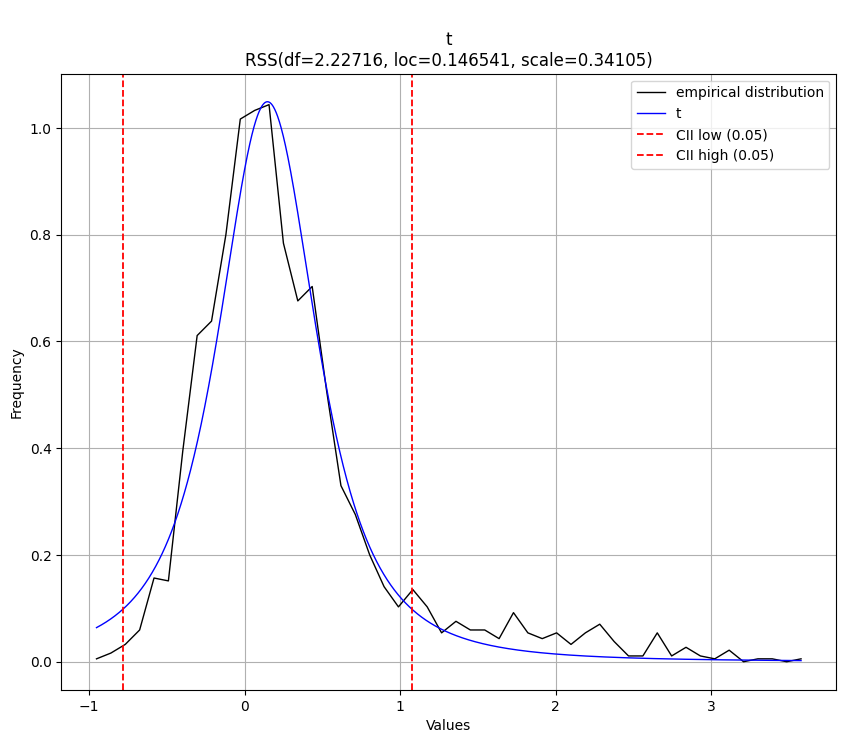

In [112]:
# Plot results
dist.plot()

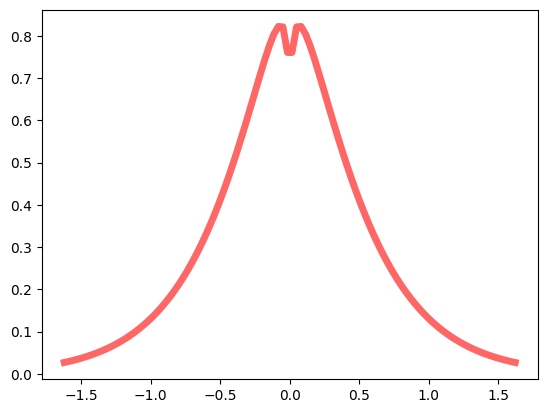

In [119]:
x = np.linspace(dweibull.ppf(0.01, c=1.12, scale=0.48 ),
                dweibull.ppf(0.99, c=1.12, scale=0.48 ), 100)
plt.plot(x, dweibull.pdf(x, c=1.12, scale=0.48),
       'r-', lw=5, alpha=0.6, label='dweibull pdf')

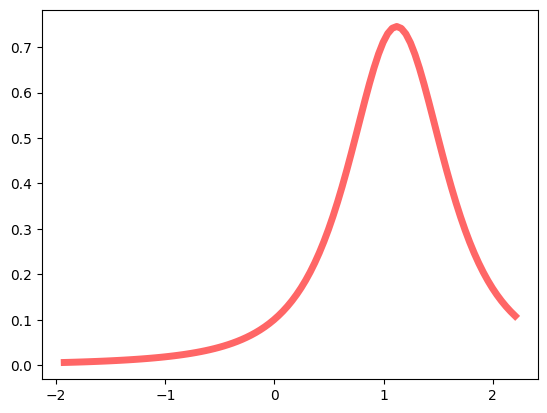

In [124]:
df = 2.22716
x = np.linspace(t.ppf(0.01, df, loc=0.14, scale=0.34 ),
                t.ppf(0.99, df, loc=0.14, scale=0.34 ), 100)
plt.plot(x, t.pdf(x,df,  loc=1.12, scale=0.48),
       'r-', lw=5, alpha=0.6, label='dweibull pdf')

### Time spent on website

In [125]:
# website_time = pd.DataFrame(gamma.ppf(unif_1, a=2, scale=5))
# website_spend =  pd.DataFrame(beta.ppf(unif_2,a=0.5, b=0.5, loc=5, scale=100))
join_time_spend = pd.concat([website_time, website_spend], axis=1)
join_time_spend.columns = ['Time', 'Cash']
gamma_dist  = ff.create_distplot([website_time.values.reshape(-1)],  group_labels = [' '])
gamma_dist.update_layout(showlegend=False, title_text='Time Spent on Website', width=1000, height=500)
gamma_dist.show()

### Dollars spent on website

In [126]:
t_dist  = ff.create_distplot([website_spend.values.reshape(-1)], group_labels = [' '])
t_dist.update_layout(showlegend=False, title_text='Dollars Spent on Website', width=1000, height=500)
t_dist.show()

In [127]:
fig = px.scatter(join_time_spend, x = 'Time', y='Cash', width=1000, height=500,  
                 #range_y=[0,110], 
                 trendline='ols', trendline_color_override='DeepPink',  marginal_x='histogram', marginal_y='histogram')
fig.show()

In [57]:
print("Corrlation between time and $$ is: " + str(round(join_time_spend.corr().values[0][1],4)))

Corrlation between time and $$ is: 0.5157


Transforming distributions to make our lives easier

In [128]:
#time_cdf =  pd.DataFrame(gamma.cdf(website_time.values, a = 2, scale=5))
time_cdf =  pd.DataFrame(dweibull.cdf(website_time.values, c=1.12, scale = 0.48))
#time_cdf = pd.DataFrame(np.cumsum(website_time.values))
time_cdf_vs_original = pd.concat([time_cdf, website_time], axis=1)
time_cdf_vs_original.columns = ['CDF', 'Original']

time_cdf_vs_original_plot = px.scatter(time_cdf_vs_original, x = 'Original', y='CDF', width=1000, height=500, title='Gamma Cumulative Distribution Function for Time',  marginal_x='histogram', marginal_y='histogram')
time_cdf_vs_original_plot.show()

In [132]:
#time_cdf =  pd.DataFrame(gamma.cdf(website_time.values, a = 2, scale=5))
time_cdf =  pd.DataFrame(dweibull.cdf(website_time.values, c=1.12, scale = 0.48))

#time_cdf = pd.DataFrame(np.cumsum(website_time.values))
time_cdf_plot  = ff.create_distplot([time_cdf.values.reshape(-1)], group_labels = [' '], show_curve=False, bin_size=0.05)
time_cdf_plot.update_layout(showlegend=False, title_text='Uniform distribution of time spent on site', width=1000, height=500)
time_cdf_plot.show()

In [133]:
dollar_cdf = pd.DataFrame(beta.cdf(website_spend.values,a=0.5, b=0.5, loc=5, scale=100))
dollar_cdf = pd.DataFrame(norm.cdf(website_spend.values))

dollar_cdf = pd.DataFrame(t.cdf(website_spend.values, df, loc=0.14, scale=0.34))

#dollar_cdf = pd.DataFrame(np.cumsum((website_spend.values)))
dollar_cdf_vs_original = pd.concat([dollar_cdf, website_spend], axis=1)
dollar_cdf_vs_original.columns = ['CDF', 'Original']

dollar_cdf_vs_original_plot = px.scatter(dollar_cdf_vs_original, x = 'Original', y='CDF', width=1000, height=500, title='Beta Cumulative Distribution Function for Dollars Spent',  marginal_x='histogram', marginal_y='histogram')
dollar_cdf_vs_original_plot.show()

In [134]:
dollar_cdf_plot  = ff.create_distplot([dollar_cdf.values.reshape(-1)], group_labels = [' '], show_curve=False, bin_size=0.05)
dollar_cdf_plot.update_layout(showlegend=False, title_text='Uniform distribution of Dollars spent on site', width=1000, height=500)
dollar_cdf_plot.show()

In [135]:
join_time_spend_uniform = pd.concat([dollar_cdf, time_cdf], axis=1)
join_time_spend_uniform.columns = ['Time', 'Cash']

time_v_money_uniform = px.scatter(join_time_spend_uniform, x = 'Time', y='Cash', width=1000, height=500,  marginal_x='histogram', marginal_y='histogram', title='Dollars vs Time in Copula Space', trendline='ols', trendline_color_override='DeepPink', )
time_v_money_uniform.show()

In [136]:
print("Corrlation between uniform time and $$ is: " + str(round(join_time_spend_uniform.corr().values[0][1],4)))

Corrlation between uniform time and $$ is: 0.2476


In [137]:
import plotly.graph_objects as go

import numpy as np

t = np.linspace(-1, 1.2, 2000)
x = (t**3) + (0.3 * np.random.randn(2000))
y = (t**6) + (0.3 * np.random.randn(2000))
x = join_time_spend_uniform['Time']
y = join_time_spend_uniform['Cash']

fig = go.Figure()
fig.add_trace(go.Histogram2dContour(
        x = x,
        y = y,
        colorscale = 'Blues',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y'
    ))
fig.add_trace(go.Scatter(
        x = x,
        y = y,
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'rgba(0,0,0,0.3)',
            size = 3
        )
    ))
fig.add_trace(go.Histogram(
        y = y,
        xaxis = 'x2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))
fig.add_trace(go.Histogram(
        x = x,
        yaxis = 'y2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False
)

fig.show()
